In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
from exp.nb_06 import *

## ConvNet

In [ ]:
x_train,y_train,x_valid,y_valid = get_data()

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [ ]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [ ]:
nfs = [8,16,32,32]

In [ ]:
def get_cnn_layers(data, nfs, **kwargs):
    nfs = [1] + nfs
    return [conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_runner(model, data, lr=0.6, loss_func = F.cross_entropy):
    opt = optim.SGD(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=cbfs)

def get_learn_run(nfs, data, lr, cbs=None, leak=0.1, sub=0.4, maxv=6.):
    model = nn.Sequential(*get_cnn_layers(data, nfs, leak=leak, sub=sub, maxv=maxv))
    init_cnn(model)
    return get_runner(model, data, lr=lr)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.8)

In [ ]:
%time run.fit(1, learn)

train: [0.5218110546875, tensor(0.8417, device='cuda:0')]
valid: [0.15871717529296875, tensor(0.9545, device='cuda:0')]
CPU times: user 2.77 s, sys: 802 ms, total: 3.57 s
Wall time: 3.48 s


## Batchnorm

### Custom

In [ ]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.zeros(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))
        self.steps = 0

    def update_stats(self, x):
        self.steps += 1
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.detach_()
        self.vars.detach_()
        mom = 1. if self.steps==1 else self.mom
        self.means.lerp_(m, mom)
        self.vars.lerp_ (v, mom)
        
    def forward(self, x):
        if self.training: self.update_stats(x)
        x = (x-self.means).div_((self.vars+self.eps).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [ ]:
def conv2d(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.9)

train: [0.4247528515625, tensor(0.8723, device='cuda:0')]
valid: [0.15681895751953126, tensor(0.9540, device='cuda:0')]


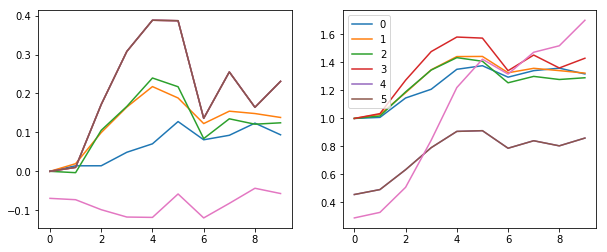

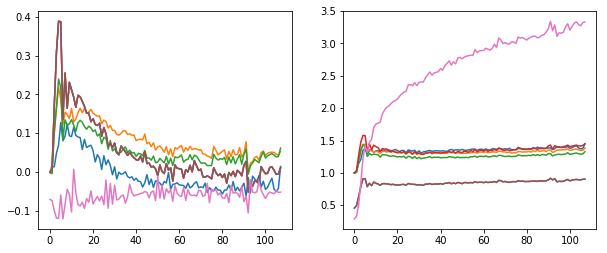

In [ ]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

In [ ]:
learn,run = get_learn_run(nfs, data, 1.0)

In [ ]:
%time run.fit(3, learn)

train: [0.4270889453125, tensor(0.8674, device='cuda:0')]
valid: [0.1574052978515625, tensor(0.9538, device='cuda:0')]
train: [0.141321171875, tensor(0.9570, device='cuda:0')]
valid: [0.1134663330078125, tensor(0.9656, device='cuda:0')]
train: [0.097023193359375, tensor(0.9705, device='cuda:0')]
valid: [0.10197774658203125, tensor(0.9700, device='cuda:0')]
CPU times: user 3.75 s, sys: 449 ms, total: 4.19 s
Wall time: 4.21 s


### Bias corrected

See XL file *mom_bias.xlsx*.

In [ ]:
optim.SGD()

In [ ]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.zeros(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))
        self.steps = 0

    def update_stats(self, x):
        self.steps += 1
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.detach_()
        self.vars.detach_()
        mom = self.mom
        self.means.lerp_(m, mom)
        self.vars.lerp_ (v, mom)
        
    def forward(self, x):
        if self.training: self.update_stats(x)
        means = self.means
        vars  = self.vars
        if self.steps<100:
            corr = 1-(1-self.mom)**self.steps
            means = means/corr
            vars  = vars /corr
        x = (x-means).div_((vars+self.eps).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [ ]:
learn,run = get_learn_run(nfs, data, 1.0)

In [ ]:
%time run.fit(3, learn)

train: [0.409007578125, tensor(0.8792, device='cuda:0')]
valid: [0.16397078857421876, tensor(0.9487, device='cuda:0')]
train: [0.140029892578125, tensor(0.9574, device='cuda:0')]
valid: [0.123492578125, tensor(0.9648, device='cuda:0')]
train: [0.09799765625, tensor(0.9704, device='cuda:0')]
valid: [0.08464044189453125, tensor(0.9749, device='cuda:0')]
CPU times: user 3.93 s, sys: 355 ms, total: 4.28 s
Wall time: 4.28 s


### jit

In [ ]:
#export
from torch.jit import ScriptModule, script_method, script
from typing import *

In [ ]:
class BatchNorm(ScriptModule):
    __constants__ = ['mom', 'eps']
    def __init__(self, nf, mom=0.1, eps=1e-3):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.zeros(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))
        self.register_buffer('steps', tensor(0))

    @script_method
    def update_stats(self, x):
        self.steps += 1
        self.means.detach_()
        self.vars.detach_()
        if bool(self.steps>100) and bool(self.steps % 2): return
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        if bool(self.steps==1):
            self.means.copy_(m)
            self.vars .copy_(v)
        else:
            self.means.copy_(self.means*(1-self.mom) + m*self.mom)
            self.vars .copy_(self.vars *(1-self.mom) + v*self.mom)

    @script_method
    def forward(self, x):
        if self.training: self.update_stats(x)
        x = (x-self.means).div((self.vars+self.eps).sqrt())
        return x.mul(self.mults).add(self.adds)

In [ ]:
learn,run = get_learn_run(nfs, 0.8)

In [ ]:
%time run.fit(3, learn)

train: [0.4505270703125, tensor(0.8677, device='cuda:0')]
valid: [0.18385860595703124, tensor(0.9452, device='cuda:0')]
train: [0.1617141015625, tensor(0.9501, device='cuda:0')]
valid: [0.12416044921875, tensor(0.9642, device='cuda:0')]
train: [0.114721123046875, tensor(0.9653, device='cuda:0')]
valid: [0.09863848876953125, tensor(0.9700, device='cuda:0')]
CPU times: user 3.87 s, sys: 171 ms, total: 4.04 s
Wall time: 4.04 s


### jit

In [ ]:
#export
from torch.jit import ScriptModule, script_method, script
from typing import *

In [ ]:
class BatchNorm2(nn.Module):
    __constants__ = ['mom', 'eps']
    def __init__(self, nf, mom=0.01, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums',  torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs',  torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step',  tensor(0.))
        self.register_buffer('dbias', tensor(0.))

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        self.mom1 = 1 - (1-self.mom)**x.shape[0]
        s  = x.sum(dims, keepdim=True)
        ss = x.pow(2).sum(dims, keepdim=True)
        c  = x.numel()/nc
        self.sums.copy_ (self.sums .add(self.mom1, s -self.sums))
        self.sqrs.copy_ (self.sqrs .add(self.mom1, ss-self.sqrs))
        self.count.copy_(self.count.add(self.mom1, c-self.count))
        self.dbias.copy_(self.mom1 + self.dbias*(1-self.mom1))
        self.batch += bs
        self.step  += 1

    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        if self.step<100:
            sums = sums/self.dbias
            sqrs = sqrs/self.dbias
        means = self.sums/self.count
        vars  = self.sqrs/self.count - means.pow(2)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x-means).div((vars+self.eps).sqrt())
        return x*self.mults + self.adds

In [ ]:
class BatchNorm2(ScriptModule):
    __constants__ = ['mom', 'eps']
    def __init__(self, nf, mom=0.1, eps=1e-3):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (1,nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(1,nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('coun', torch.zeros(1,nf,1,1))
        self.register_buffer('steps', tensor(0))

    @script_method
    def update_stats(self, x):
        nc = x.shape[1]
        self.steps += 1
        self.sqrs.detach_()
        self.sums.detach_()
        # if bool(self.steps>100) and bool(self.steps % 2): return
        dims = (0,2,3)
        s  = x    .sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c  = x.numel()/nc
        if bool(self.steps==1):
            self.sums.copy_(s)
            self.sqrs.copy_(ss)
            self.coun.copy_(c)
        else:
            self.sums.copy_(self.sums*(1-self.mom) + s *self.mom)
            self.sqrs.copy_(self.sqrs*(1-self.mom) + ss*self.mom)
            self.coun.copy_(self.coun*(1-self.mom) + c *self.mom)

    @script_method
    def forward(self, x):
        if self.training: self.update_stats(x)
        means = self.sums/self.coun
        vars  = self.sqrs/self.coun - means.pow(2)
        x = (x-means) / ((vars+self.eps).sqrt())
        return x*self.mults + self.adds

In [ ]:
def conv2d(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm2(nf))
    return nn.Sequential(*layers)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.8)

In [ ]:
%time run.fit(3, learn)

train: [0.079270703125, tensor(0.9763, device='cuda:0')]
valid: [0.08132650146484376, tensor(0.9758, device='cuda:0')]
train: [0.0634197607421875, tensor(0.9816, device='cuda:0')]
valid: [0.07836026000976562, tensor(0.9761, device='cuda:0')]
train: [0.0550289306640625, tensor(0.9839, device='cuda:0')]
valid: [0.09280201416015625, tensor(0.9725, device='cuda:0')]
CPU times: user 4.25 s, sys: 516 ms, total: 4.77 s
Wall time: 4.77 s


### Builtin batchnorm

In [ ]:
#export
def conv2d(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-3))
    return nn.Sequential(*layers)

In [ ]:
learn,run = get_learn_run(nfs, data, 1.0)

In [ ]:
%time run.fit(3, learn)

train: [0.4437156640625, tensor(0.8695, device='cuda:0')]
valid: [0.1359041748046875, tensor(0.9602, device='cuda:0')]
train: [0.11120369140625, tensor(0.9661, device='cuda:0')]
valid: [0.08841785888671876, tensor(0.9738, device='cuda:0')]
train: [0.079300078125, tensor(0.9763, device='cuda:0')]
valid: [0.107217041015625, tensor(0.9689, device='cuda:0')]
CPU times: user 3.09 s, sys: 348 ms, total: 3.44 s
Wall time: 3.45 s


### With scheduler

In [ ]:
sched = combine_scheds([0.5, 0.5], [sched_lin(0.2, 1.), sched_lin(1., 0.1)]) 

In [ ]:
learn,run = get_learn_run(nfs, data, 1., cbs=ParamScheduler('lr', sched))

In [ ]:
run.fit(8, learn)

train: [0.4314221484375, tensor(0.8787, device='cuda:0')]
valid: [0.1140492431640625, tensor(0.9683, device='cuda:0')]
train: [0.102120380859375, tensor(0.9695, device='cuda:0')]
valid: [0.08423486938476563, tensor(0.9760, device='cuda:0')]
train: [0.072295810546875, tensor(0.9787, device='cuda:0')]
valid: [0.07796448974609375, tensor(0.9761, device='cuda:0')]
train: [0.0582051318359375, tensor(0.9824, device='cuda:0')]
valid: [0.0651952880859375, tensor(0.9801, device='cuda:0')]
train: [0.0478931201171875, tensor(0.9857, device='cuda:0')]
valid: [0.061673541259765624, tensor(0.9822, device='cuda:0')]
train: [0.0414492431640625, tensor(0.9877, device='cuda:0')]
valid: [0.05984327392578125, tensor(0.9823, device='cuda:0')]
train: [0.0365991015625, tensor(0.9887, device='cuda:0')]
valid: [0.0609909912109375, tensor(0.9839, device='cuda:0')]
train: [0.0328167578125, tensor(0.9898, device='cuda:0')]
valid: [0.0601783447265625, tensor(0.9836, device='cuda:0')]


## More norms

### Layer norm

From [the paper](https://arxiv.org/abs/1607.06450): "*batch normalization cannot be applied to online learning tasks or to extremely large distributed models where the minibatches have to be small*".

General equation for a norm layer with learnable affine:

$$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

In [ ]:
class LayerNorm(ScriptModule):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    @script_method
    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.std ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [ ]:
def conv2d(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.5)

In [ ]:
%time run.fit(3, learn)

train: [0.4526175, tensor(0.8583, device='cuda:0')]
valid: [0.1315213623046875, tensor(0.9623, device='cuda:0')]
train: [0.1259929296875, tensor(0.9618, device='cuda:0')]
valid: [0.108642041015625, tensor(0.9664, device='cuda:0')]
train: [0.088629716796875, tensor(0.9735, device='cuda:0')]
valid: [0.08789295043945312, tensor(0.9742, device='cuda:0')]
CPU times: user 4.57 s, sys: 484 ms, total: 5.05 s
Wall time: 5.06 s


*Thought experiment*: can this distinguish green frogs from red frogs (assuming you're using it before the first conv)?

### Instance norm

From [the paper](https://arxiv.org/abs/1607.08022): 

The key difference between **contrast** and batch normalization is that the latter applies the normalization to a  whole batch of images instead for single ones:

\begin{equation}\label{eq:bnorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{i}}{\sqrt{\sigma_i^2 + \epsilon}},
    \quad
    \mu_i = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_i^2 = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_i)^2.
\end{equation}

In order to combine the effects of instance-specific normalization and batch normalization, we propose to replace the latter by the *instance normalization* (also known as *contrast normalization*) layer:

\begin{equation}\label{eq:inorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{ti}}{\sqrt{\sigma_{ti}^2 + \epsilon}},
    \quad
    \mu_{ti} = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_{ti}^2 = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_{ti})^2.
\end{equation}

In [ ]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))

    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.std ((2,3), keepdim=True)
        res = (x-m) / ((v+self.eps).sqrt())
        return res*self.mults + self.adds

In [ ]:
def conv2d(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.1)

In [ ]:
%time run.fit(3, learn)

train: [2.30253484375, tensor(0.1128, device='cuda:0')]
valid: [2.3023453125, tensor(0.1064, device='cuda:0')]
train: [2.301203125, tensor(0.1136, device='cuda:0')]
valid: [2.30204765625, tensor(0.1064, device='cuda:0')]
train: [2.30111546875, tensor(0.1136, device='cuda:0')]
valid: [2.302075390625, tensor(0.1064, device='cuda:0')]
CPU times: user 3.73 s, sys: 620 ms, total: 4.35 s
Wall time: 4.36 s


*Question*: why can't this classify anything?

### Group norm

*From the PyTorch docs:*

`GroupNorm(num_groups, num_channels, eps=1e-5, affine=True)`

The input channels are separated into `num_groups` groups, each containing
``num_channels / num_groups`` channels. The mean and standard-deviation are calculated
separately over the each group. $\gamma$ and $\beta$ are learnable
per-channel affine transform parameter vectorss of size `num_channels` if
`affine` is ``True``.

This layer uses statistics computed from input data in both training and
evaluation modes.

Args:
-    num_groups (int): number of groups to separate the channels into
-    num_channels (int): number of channels expected in input
-    eps: a value added to the denominator for numerical stability. Default: 1e-5
-    affine: a boolean value that when set to ``True``, this module
        has learnable per-channel affine parameters initialized to ones (for weights)
        and zeros (for biases). Default: ``True``.

Shape:
- Input: :math:`(N, num\_channels, *)`
- Output: :math:`(N, num\_channels, *)` (same shape as input)

Examples::

    >>> input = torch.randn(20, 6, 10, 10)
    >>> # Separate 6 channels into 3 groups
    >>> m = nn.GroupNorm(3, 6)
    >>> # Separate 6 channels into 6 groups (equivalent with InstanceNorm)
    >>> m = nn.GroupNorm(6, 6)
    >>> # Put all 6 channels into a single group (equivalent with LayerNorm)
    >>> m = nn.GroupNorm(1, 6)
    >>> # Activating the module
    >>> output = m(input)

## Fix small batch sizes

### Exponentially Weighted Layer Norm

In [ ]:
class EWLayerNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('sum'  , tensor(0.))
        self.register_buffer('sqr'  , tensor(0.))
        self.register_buffer('count', tensor(0.))

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sum.detach_()
        self.sqr.detach_()
        mom = 1 if self.batch==0 else self.mom
        self.sum  .add_(mom, x.sum()     - self.sum  )
        self.sqr  .add_(mom, (x*x).sum() - self.sqr  )
        self.count.add_(mom, x.numel()   - self.count)
        self.batch += bs

    def forward(self, x):
        if self.training: self.update_stats(x)
        mean = self.sum/self.count
        var  = self.sqr/self.count - mean.pow(2)
        x = (x-mean)/((var+self.eps).sqrt())
        return x*self.mult + self.add

In [ ]:
def conv2d(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(EWLayerNorm(nf))
    return nn.Sequential(*layers)

In [ ]:
learn,run = get_learn_run(nfs, 0.5)

In [ ]:
%time run.fit(3, learn)

train: [0.074243193359375, tensor(0.9766, device='cuda:0')]
valid: [0.08686154174804687, tensor(0.9731, device='cuda:0')]
train: [0.059469072265625, tensor(0.9819, device='cuda:0')]
valid: [0.096335546875, tensor(0.9706, device='cuda:0')]
train: [0.053373134765625, tensor(0.9833, device='cuda:0')]
valid: [0.07646878051757812, tensor(0.9772, device='cuda:0')]
CPU times: user 3.68 s, sys: 280 ms, total: 3.96 s
Wall time: 3.97 s


### Exponentially Weighted Batch Norm

In [ ]:
class EWBatchNorm(nn.Module):
    __constants__ = ['mom', 'eps']
    def __init__(self, nf, mom=0.01, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums',  torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs',  torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step',  tensor(0.))
        self.register_buffer('dbias', tensor(0.))

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        self.mom1 = 1 - (1-self.mom)**x.shape[0]
        s  = x.sum(dims, keepdim=True)
        ss = x.pow(2).sum(dims, keepdim=True)
        c  = x.numel()/nc
        self.sums.copy_ (self.sums .add(self.mom1, s -self.sums))
        self.sqrs.copy_ (self.sqrs .add(self.mom1, ss-self.sqrs))
        self.count.copy_(self.count.add(self.mom1, c-self.count))
        self.dbias.copy_(self.mom1 + self.dbias*(1-self.mom1))
        self.batch += bs
        self.step  += 1

    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        if self.step<100:
            sums = sums/self.dbias
            sqrs = sqrs/self.dbias
        means = self.sums/self.count
        vars  = self.sqrs/self.count - means.pow(2)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x-means).div((vars+self.eps).sqrt())
        return x*self.mults + self.adds

In [ ]:
def conv2d(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(EWBatchNorm(nf))
    return nn.Sequential(*layers)

In [ ]:
learn,run = get_learn_run(nfs, data, 1.0)

In [ ]:
%time run.fit(3, learn)

train: [0.33104734375, tensor(0.9050, device='cuda:0')]
valid: [0.111326513671875, tensor(0.9681, device='cuda:0')]
train: [0.088771162109375, tensor(0.9726, device='cuda:0')]
valid: [0.07529160766601563, tensor(0.9775, device='cuda:0')]
train: [0.059317353515625, tensor(0.9819, device='cuda:0')]
valid: [0.07531204833984376, tensor(0.9759, device='cuda:0')]
CPU times: user 4.93 s, sys: 536 ms, total: 5.46 s
Wall time: 5.47 s


In [ ]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.3, 1.2), sched_cos(1., 0.1)]) 

In [ ]:
learn,run = get_learn_run(nfs, data, 1., cbs=ParamScheduler('lr', sched))

In [ ]:
run.fit(8, learn)

train: [0.34060890625, tensor(0.9043, device='cuda:0')]
valid: [0.29444873046875, tensor(0.9061, device='cuda:0')]
train: [0.091703251953125, tensor(0.9726, device='cuda:0')]
valid: [0.09838342895507812, tensor(0.9697, device='cuda:0')]
train: [0.0651663623046875, tensor(0.9801, device='cuda:0')]
valid: [0.06815178833007812, tensor(0.9798, device='cuda:0')]
train: [0.051250078125, tensor(0.9844, device='cuda:0')]
valid: [0.065077880859375, tensor(0.9811, device='cuda:0')]
train: [0.0417406640625, tensor(0.9877, device='cuda:0')]
valid: [0.07483850708007812, tensor(0.9760, device='cuda:0')]
train: [0.03471643798828125, tensor(0.9903, device='cuda:0')]
valid: [0.06753575439453124, tensor(0.9795, device='cuda:0')]
train: [0.02933214111328125, tensor(0.9912, device='cuda:0')]
valid: [0.05319308471679687, tensor(0.9832, device='cuda:0')]
train: [0.024283916015625, tensor(0.9928, device='cuda:0')]
valid: [0.053880108642578126, tensor(0.9845, device='cuda:0')]


## Export

In [ ]:
!./notebook2script.py 07_batchnorm.ipynb

Converted 07_batchnorm.ipynb to nb_07.py
